## Setup


This small code will perform LSTM from scratch a try to predicted the X data who will represented here trajectory of a ball in football game ^^

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
X = torch.randn(10, 1, dtype=torch.float32)
y = torch.randint(0, 3, (10, 1), dtype=torch.float32)
print((X[:3], y[:3]))

(tensor([[ 1.3558],
        [ 0.8453],
        [-0.0506]]), tensor([[1.],
        [2.],
        [0.]]))


## Code

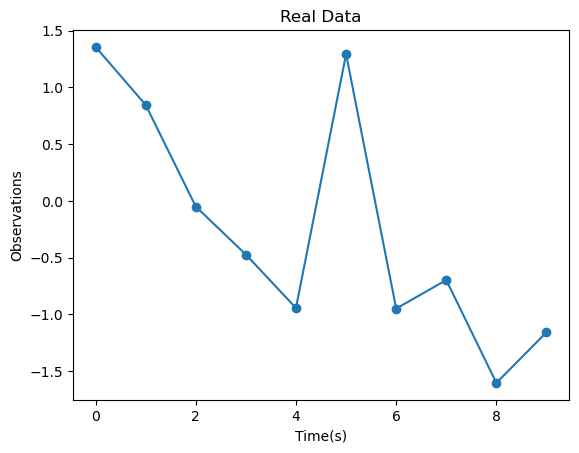

In [3]:
plt.title("Real Data")
plt.ylabel("Observations")
plt.xlabel("Time(s)")
plt.plot(X, marker = "o")
plt.show()


In [4]:
# Activations functions
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

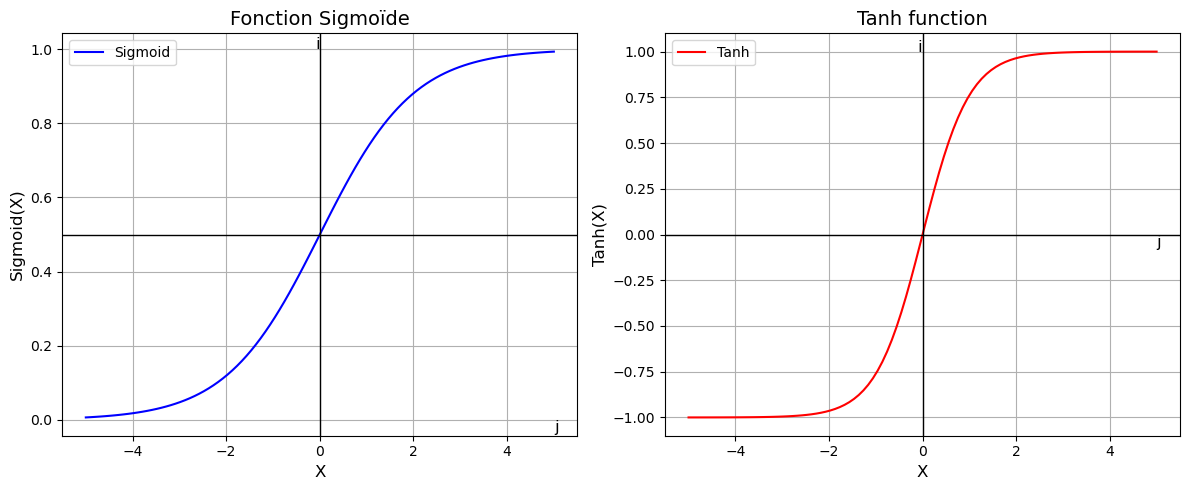

In [5]:
XA = torch.linspace(-5, 5, 100) # We define another because I want to show see well the appearance of those functions

sig_x = sigmoid(XA)
tanh_x = tanh(XA)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# sigmoïde
ax1.plot(XA.numpy(), sig_x.numpy(), label="Sigmoid", color="blue")
ax1.axhline(0.5, color='black',linewidth=1) # 0.5 cuz sigmoid have his origin on this point
ax1.axvline(0, color='black',linewidth=1)  
ax1.set_title('Fonction Sigmoïde', fontsize=14)
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Sigmoid(X)', fontsize=12)
ax1.legend()
ax1.grid(True)  
ax1.text(0, 1, 'i', fontsize=12, ha='right') 
ax1.text(5, 0, 'j', fontsize=12, va='top')  

# tanh
ax2.plot(XA.numpy(), tanh_x.numpy(), label="Tanh", color="red")
ax2.axhline(0, color='black',linewidth=1)
ax2.axvline(0, color='black',linewidth=1)
ax2.set_title('Tanh function', fontsize=14)
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Tanh(X)', fontsize=12)
ax2.legend()
ax2.grid(True)
ax2.text(0, 1, 'i', fontsize=12, ha='right')
ax2.text(5, 0, 'j', fontsize=12, va='top')

plt.tight_layout()
plt.show()

The LSTM architecture is particularly effective for tasks such as time series forecasting because it can learn which parts of the data are important to remember and which parts to forget. By controlling the flow of information through the different gates, LSTM networks can capture long-term dependencies in sequential data, allowing them to predict future events based on both recent and past information.

The three gates—forget, input, and output—work together to maintain and modify the cell state, which stores the “memory” of the network across time steps. This dynamic memory update is what makes LSTMs so powerful compared to traditional RNNs, which struggle with retaining long-term dependencies

- The forget gate
- The input gate
- The output gate

The **forget gate** is the gate used to delete or forget ^^ values dont the model estimate isn't helpful. The formula is:
$$ f_t = \sigma(W \times [h_{t-1}, X_t] + b) $$

The **input gate** is used to let's enter values and takes the $h{t-1}$ which is the prediction of the previous interation and $X$ the data. In the input gate make also the update of the cell. We will implement $\tilde{C_t}$. It's an array use a tanh activation to store values.
$$i_t = \sigma(W_i \times [h_{i-1}, X_i] + b_i)$$
$$\tilde{C_t} = \sigma(W_c \times [h_{c-1}, X_c] + b_c)$$

The **output gate** is the prediction of the LSTM cell.
$$o_t = \sigma(W_o \times [h_{o-1}, X_o] + b_o)$$
$$h_t = o_t \times tanh(C_t)$$


Don't forget the update cell which operation is $C_t = f_t \times X + i_t \times \tilde{C_t}$


In [6]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases with requires_grad=True
        self.W_i = torch.randn(hidden_size, input_size + hidden_size, dtype=torch.float32, requires_grad=True)  # Input gate weights
        self.W_f = torch.randn(hidden_size, input_size + hidden_size, dtype=torch.float32, requires_grad=True)  # Forget gate weights
        self.W_o = torch.randn(hidden_size, input_size + hidden_size, dtype=torch.float32, requires_grad=True)  # Output gate weights
        self.W_c = torch.randn(hidden_size, input_size + hidden_size, dtype=torch.float32, requires_grad=True)  # Cell state weights
        
        self.b_i = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)
        self.b_f = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)
        self.b_o = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)
        self.b_c = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)
        
        # Initialize hidden and cell states (these don't need grad)
        self.h = torch.zeros(hidden_size, dtype=torch.float32)
        self.C = torch.zeros(hidden_size, dtype=torch.float32)
    
    def input_gate(self, X):
        combined = torch.cat((self.h, X), axis=0)
        i_t = sigmoid(torch.matmul(self.W_i, combined) + self.b_i)
        C_tilde = tanh(torch.matmul(self.W_c, combined) + self.b_c)
        return i_t, C_tilde
    
    def forget_gate(self, X):
        combined = torch.cat((self.h, X), axis=0)
        f_t = sigmoid(torch.matmul(self.W_f, combined) + self.b_f)
        return f_t
    
    def output_gate(self, X, C_t):
        combined = torch.cat((self.h, X), axis=0)
        o_t = sigmoid(torch.matmul(self.W_o, combined) + self.b_o)
        h_t = o_t * tanh(C_t)
        return h_t
    
    def step(self, X):
        """One LSTM step"""
        # Forget gate
        f_t = self.forget_gate(X)
        
        # Input gate
        i_t, C_tilde = self.input_gate(X)
        
        # Update cell state
        self.C = f_t * self.C + i_t * C_tilde
        
        # Output gate
        self.h = self.output_gate(X, self.C)
        
        return self.h[:self.output_size]
    
    def predict(self, X_seq):
        """Predictions of next values"""
        predictions = []
        for X in X_seq:
            pred = self.step(X)
            predictions.append(pred)
        return torch.stack(predictions)
    
    def train(self, X_seq, y_seq, epochs=1, lr=0.01):
        """Training loop with optional epochs"""
        optimizer = torch.optim.Adam([self.W_i, self.W_f, self.W_o, self.W_c, self.b_i, self.b_f, self.b_o, self.b_c], lr=lr)
        loss_function = torch.nn.MSELoss()  # Mean Squared Error
        
        losses = []
        
        for epoch in range(epochs):
            # Reset hidden and cell states at the start of each epoch
            self.h = torch.zeros(self.hidden_size, dtype=torch.float32)
            self.C = torch.zeros(self.hidden_size, dtype=torch.float32)
            
            # Forward pass: predictions
            predictions = self.predict(X_seq)
            
            # Compute the loss
            loss = loss_function(predictions, y_seq)
            losses.append(loss.item())
            
            # Backward pass
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
            # Print the loss for each epoch
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
        
        # Plot the loss over epochs
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, epochs + 1), losses, marker='x', label='Training Loss')
        plt.title('Training Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

Epoch 1/1, Loss: 1.3348028659820557


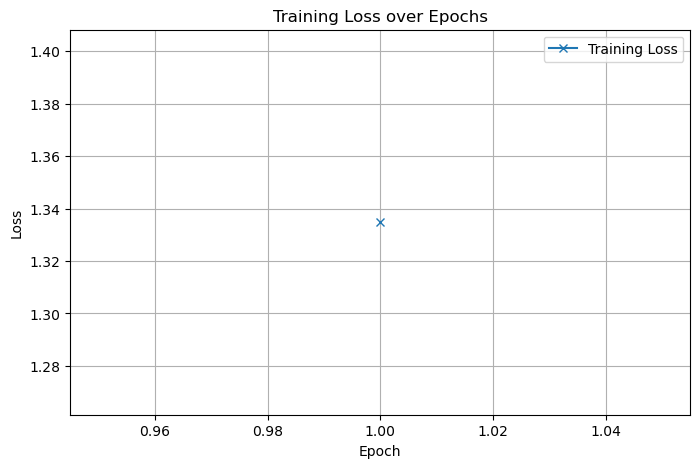

Predicted => 0.5010 | Expected => 1.3558
Predicted => 0.6284 | Expected => 0.8453
Predicted => 0.4117 | Expected => -0.0506
Predicted => 0.1870 | Expected => -0.4736
Predicted => 0.1125 | Expected => -0.9446
Predicted => 0.2176 | Expected => 1.2932
Predicted => 0.0331 | Expected => -0.9496
Predicted => -0.0404 | Expected => -0.6981
Predicted => -0.0499 | Expected => -1.6045
Predicted => -0.1191 | Expected => -1.1581


In [7]:
# Initialize the LSTM model
lstm = LSTM(input_size=1, hidden_size=20, output_size=1)
# Train the model with 1 epoch by default
lstm.train(X_seq=X, y_seq=y)
predictions = lstm.predict(X)
for i in range(len(predictions)):
    print("Predicted => {:.4f} | Expected => {:.4f}".format(predictions[i].detach().numpy().item(), X[i].detach().numpy().item()))

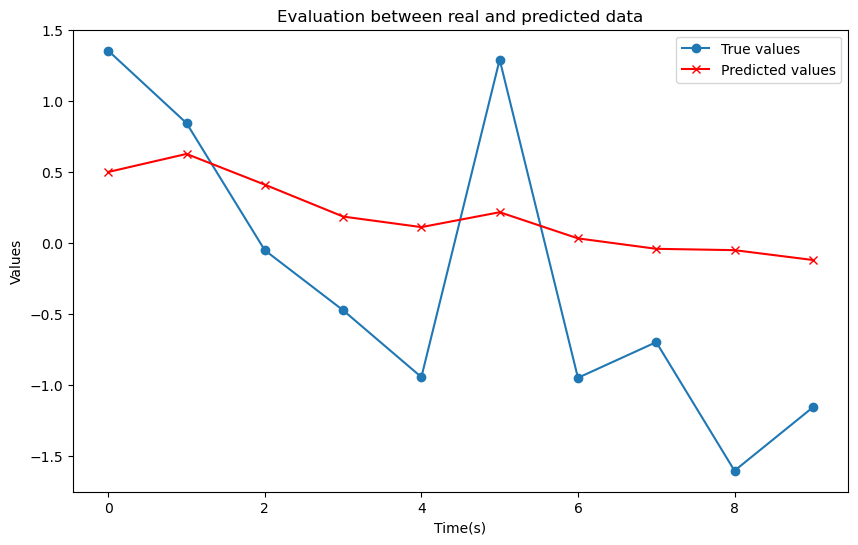

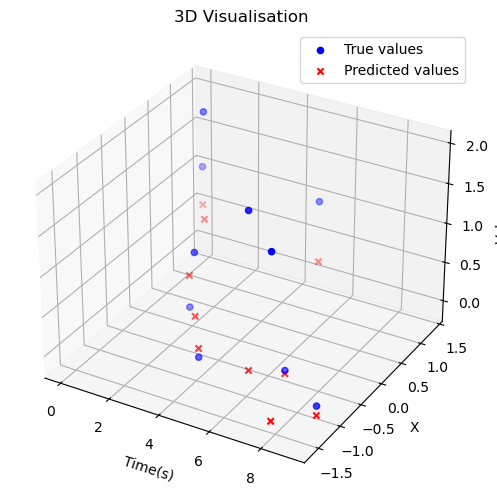

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(X, label='True values', marker='o')
plt.plot(predictions.detach().numpy(), label='Predicted values', marker='x', color = 'red')
plt.legend()
plt.title('Evaluation between real and predicted data')
plt.xlabel('Time(s)')
plt.ylabel('Values')
plt.show()

# 3D Visualisation 
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

time_steps = torch.arange(10)
ax.scatter(time_steps.numpy(), X.numpy(), y.numpy(), label='True values', color='blue', marker='o')
ax.scatter(time_steps.numpy(), X.numpy(), predictions.detach().numpy(), label='Predicted values', color='red', marker='x')

ax.set_title('3D Visualisation')
ax.set_xlabel('Time(s)')
ax.set_ylabel('X')
ax.set_zlabel('Values')
plt.legend()
plt.show()

Epoch 1/100, Loss: 1.2262306213378906
Epoch 2/100, Loss: 1.128882884979248
Epoch 3/100, Loss: 1.0677249431610107
Epoch 4/100, Loss: 1.007354497909546
Epoch 5/100, Loss: 0.9479754567146301
Epoch 6/100, Loss: 0.8977953195571899
Epoch 7/100, Loss: 0.8610669374465942
Epoch 8/100, Loss: 0.836957573890686
Epoch 9/100, Loss: 0.8218125104904175
Epoch 10/100, Loss: 0.8117321133613586
Epoch 11/100, Loss: 0.8041477203369141
Epoch 12/100, Loss: 0.797757089138031
Epoch 13/100, Loss: 0.7919409871101379
Epoch 14/100, Loss: 0.7863868474960327
Epoch 15/100, Loss: 0.7809242010116577
Epoch 16/100, Loss: 0.7754553556442261
Epoch 17/100, Loss: 0.76992267370224
Epoch 18/100, Loss: 0.764288604259491
Epoch 19/100, Loss: 0.7585234045982361
Epoch 20/100, Loss: 0.7525972723960876
Epoch 21/100, Loss: 0.7464737296104431
Epoch 22/100, Loss: 0.7401057481765747
Epoch 23/100, Loss: 0.7334336042404175
Epoch 24/100, Loss: 0.7263844013214111
Epoch 25/100, Loss: 0.7188762426376343
Epoch 26/100, Loss: 0.7108224630355835
Ep

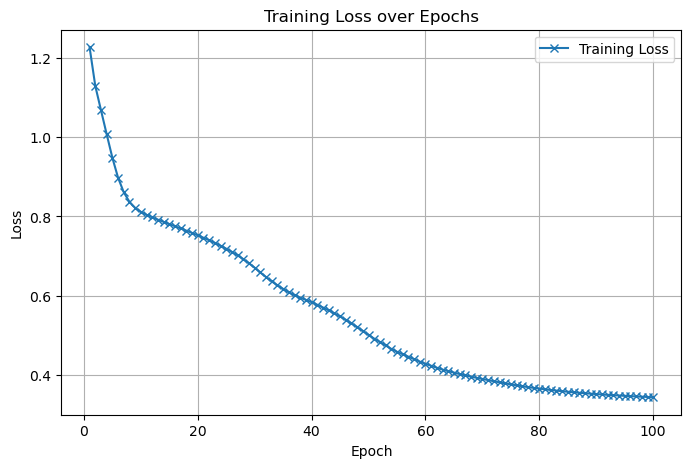

Predicted => 0.7472 | Expected => 1.0000
Predicted => 0.7958 | Expected => 2.0000
Predicted => 0.5614 | Expected => 0.0000
Predicted => 0.4265 | Expected => 1.0000
Predicted => 0.4309 | Expected => 0.0000
Predicted => 0.6101 | Expected => 1.0000
Predicted => 0.9667 | Expected => 2.0000
Predicted => 0.3480 | Expected => 0.0000
Predicted => 0.9877 | Expected => 2.0000
Predicted => -0.2209 | Expected => 0.0000


In [9]:
# Predict on the data and compare predictions to actual values
lstm.train(X_seq=X, y_seq=y, epochs=100)
predictions = lstm.predict(X)
for i in range(len(predictions)):
    print("Predicted => {:.4f} | Expected => {:.4f}".format(predictions[i].detach().numpy().item(), y[i].detach().numpy().item()))

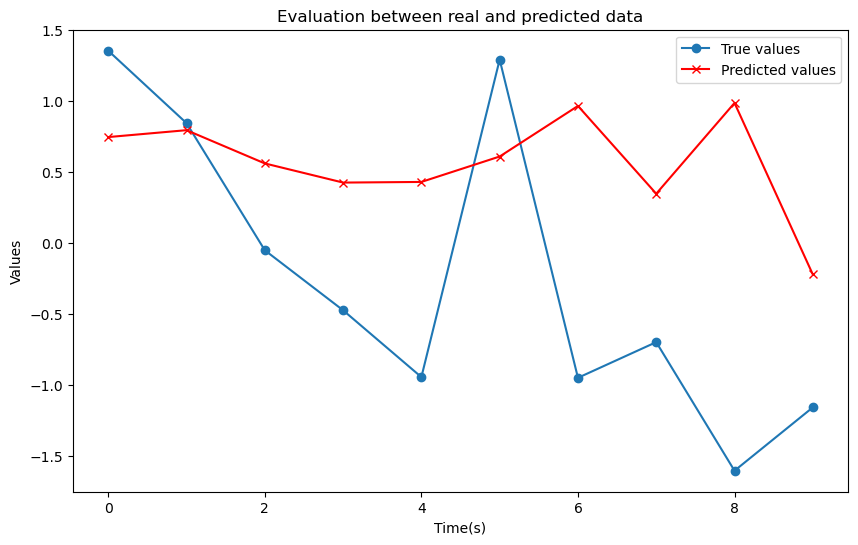

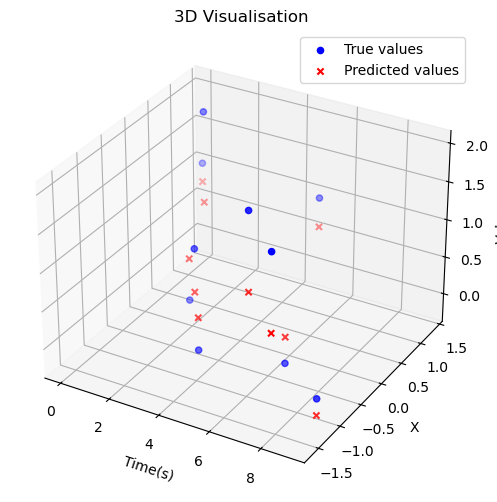

In [10]:
# 2D Plot for true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(X, label='True values', marker='o')
plt.plot(predictions.detach().numpy(), label='Predicted values', marker='x', color='red')
plt.legend()
plt.title('Evaluation between real and predicted data')
plt.xlabel('Time(s)')
plt.ylabel('Values')
plt.show()

# 3D Visualization
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

time_steps = torch.arange(10)
ax.scatter(time_steps.numpy(), X.numpy(), y.numpy(), label='True values', color='blue', marker='o')
ax.scatter(time_steps.numpy(), X.numpy(), predictions.detach().numpy(), label='Predicted values', color='red', marker='x')

ax.set_title('3D Visualisation')
ax.set_xlabel('Time(s)')
ax.set_ylabel('X')
ax.set_zlabel('Values')
plt.legend()
plt.show()